# **Classification**

#### Book used: Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow (third edition)

#### Chapter 3 practice: getting familiar with classification using the MNIST dataset

Defining default font sizes to make the figures prettier:

In [1]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

Fetching the MNIST dataset:

In [2]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False)
print(mnist.DESCR)

**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image b

Separating data from the labels and taking a look at what we have:

In [3]:
X, y = mnist.data, mnist.target

X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [4]:
X.shape

(70000, 784)

Each image has 784 features, because each image is 28x28 pixels and each feature represents the intensity of a pixel and ranges from 0 (white) to 255 (black). 

In [5]:
y

array(['5', '0', '4', ..., '4', '5', '6'], dtype=object)

In [6]:
y.shape

(70000,)

Displaying one random image:

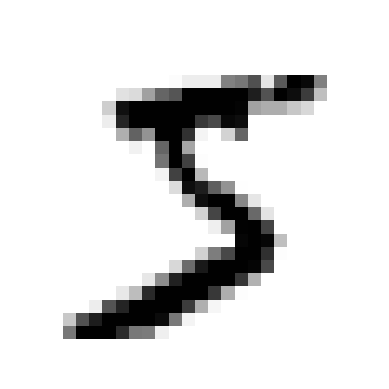

In [7]:
import matplotlib.pyplot as plt

def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")

some_digit = X[0]
plot_digit(some_digit)
plt.show()

In [8]:
y[0]

'5'

This dataset is already split into training (first 60,000 images) and testing sets (last 10,000 images) and the training set is already shuffled for us, ensuring that all cross-validation folds will be similar.

In [9]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Training a binary classifier

Training a simple binary classifier to detect fives:

In [10]:
y_train_5 = (y_train == '5')  # True for all 5s, False for all other digits
y_test_5 = (y_test == '5')

In [11]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [12]:
sgd_clf.predict([some_digit])

array([ True])

## Performance measures

### Measuring accuracy using cross-validation

Using `cross_val_score` k-fold cross-validation with three folds (splitting the training set into k folds, then training the model k times, holding out a different fold for evaluation each time):

In [13]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

Over 90% accuracy on each validation fold. However, this is not very impressive considering only about 10% of the images are 5. Therefore, if the classifier predicts "not 5" every time, it'll be correct about 90% of the time.

For this reason, accuracy isn't a very good performance measure for classifiers, especially when working with skewed datasets (where some classes are much more frequent than others.)

### Confusion matrix

Using a confusion matrix to check the accuracy of the model.

* Each row in a confusion matrix represents an actual class
* Each column represents a predicted class

In [14]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [15]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_train_5, y_train_pred)
cm

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

The first row of this confusion matrix considers non-5 images (the _negative class_): 53,892 were correctly classified as non-5s (_true negatives_) while the remaining 687 were incorrectly classified as 5s (_false positives_, also called _Type I errors_).

The second row considers the images of 5s (the _positive class_): 1,891 were wrongly classified as non-5s (_false negatives_, also called _Type II errors_), while the remaining 3,530 were correctly classified as 5s (_true positives_).

What a confusion matrix would look like if the model were perfect:

In [16]:
y_train_perfect_predictions = y_train_5  # pretend we reached perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

### Precision and recall

Precision of the classifier can be given by:

$$Precision = \frac{TP}{TP + FP},$$

where TP is the number of true positives, and FP is the number of false positives.

Precision is usually used along with another metric named _recall_, also called _sensitivity_ or _true positive rate (TPR)_. This is the ratio of positive instances that are correctly detected by the classifier:

$$Recall = \frac{TP}{TP + FN},$$

where FN is the number of false negatives.

Scikit-Learn contains functions that can calculate these easily:

In [17]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)  # == 3530 / (687 + 3530)

0.8370879772350012

In [18]:
recall_score(y_train_5, y_train_pred)  # == 3530 / (1891 + 3530)

0.6511713705958311

As we can see, when the classifier claimed an image represented a 5, it was only correct about 83.7% of the time.
Additionally, it only detected 65.1% of the 5s.

It is often convenient to combine precision and recall into a single metric called the $F_{1}$ score, especially when you need a single metric to compare two classifiers:

$$F_{1} score = 2 \cdot \frac{precision \cdot recall}{precision + recall}$$

The $F_{1}$ score is a common metric used in binary classification tasks to evaluate the performance of a classification model. It is the harmonic mean of the precision and recall of the model, and ranges from 0 to 1, where a score of 1 indicates perfect precision and recall, and a score of 0 indicates poor performance.

In [19]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

### Precision/recall tradeoff

There's a tradeoff between precision and recall. This is visualized in the following graph, showing precision and recall for all possible decision thresholds (the cut-off for deciding either a positive or negative classification):

In [20]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

In [21]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

Showing an example threshold of 3000 on the graph to see what the values of precision and recall would be:

In [22]:
threshold = 3000

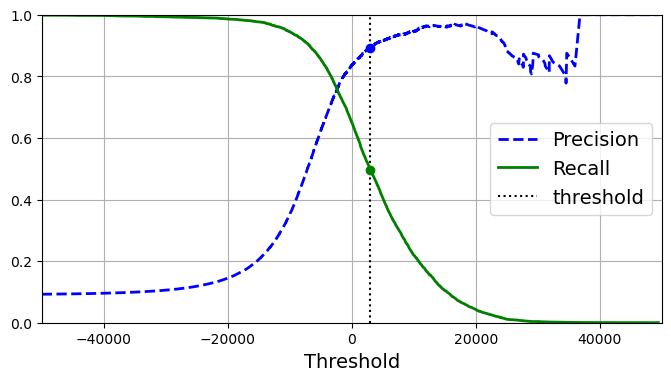

In [23]:
plt.figure(figsize=(8, 4))  # extra code – it's not needed, just formatting
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")

# extra code – this section just beautifies the figure
idx = (thresholds >= threshold).argmax()  # first index ≥ threshold
plt.plot(thresholds[idx], precisions[idx], "bo")
plt.plot(thresholds[idx], recalls[idx], "go")
plt.axis([-50000, 50000, 0, 1])
plt.grid()
plt.xlabel("Threshold")
plt.legend(loc="center right")

plt.show()

At this threshold value, precision is around 90% and recall is around 50%. Another way to visualize this is by plotting precision directly against recall:

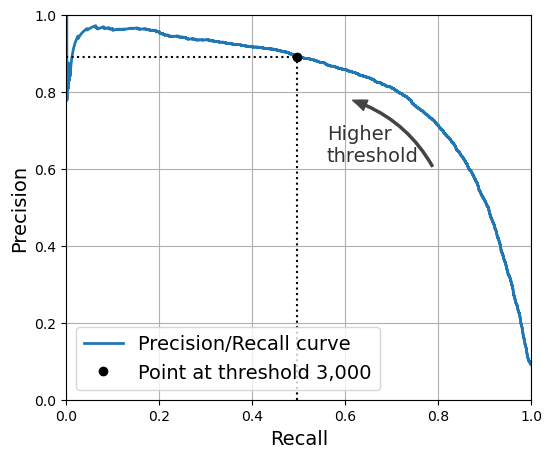

In [24]:
import matplotlib.patches as patches  # extra code – for the curved arrow

plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting

plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")

# extra code – just beautifies the figure
plt.plot([recalls[idx], recalls[idx]], [0., precisions[idx]], "k:")
plt.plot([0.0, recalls[idx]], [precisions[idx], precisions[idx]], "k:")
plt.plot([recalls[idx]], [precisions[idx]], "ko",
         label="Point at threshold 3,000")
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.79, 0.60), (0.61, 0.78),
    connectionstyle="arc3,rad=.2",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.56, 0.62, "Higher\nthreshold", color="#333333")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")

plt.show()

Evidently, precision really starts to fall sharply at around 80% recall. A good threshold would probably be just before that drop, around 60%. But it depends on the project.

If one decides to aim for 90% precision it can be done using the previous diagram, but a better way would be to use the NumPy array's `argmax()` method, which returns the first index of the maximum value, which in this case means the first True value:

In [25]:
idx_for_90_precision = (precisions >= 0.90).argmax()
threshold_for_90_precision = thresholds[idx_for_90_precision]
threshold_for_90_precision

3370.019499143957

Making predictions on the training set:

In [26]:
y_train_pred_90 = (y_scores >= threshold_for_90_precision)

Checking precision and recall:

In [27]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

90% precision was achieved, as expected!

In [28]:
recall_at_90_precision = recall_score(y_train_5, y_train_pred_90)
recall_at_90_precision

0.4799852425751706

Clearly, it's quite easy to create a classifier of any predetermined precision. However, 48% recall isn't very good for most applications.

**A high-precision classifier is not very useful if its recall is too low!**

### The ROC curve

The _receiver operating characteristic (ROC)_ curve is another common tool used with binary classifiers. It plots the true positive rate (same thing as recall) against the false positive rate (FPR). The FPR is the ratio of negative instances that are incorrectly classified as positive. It is equal to $1 - TPR$ (the true positive rate), which is the ratio of negative instances that are correctly classified as negative. The TNR is also called _specificity_. The `roc_curve()` function can be used to compute the TPR and FPR for various threshold values:

In [29]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

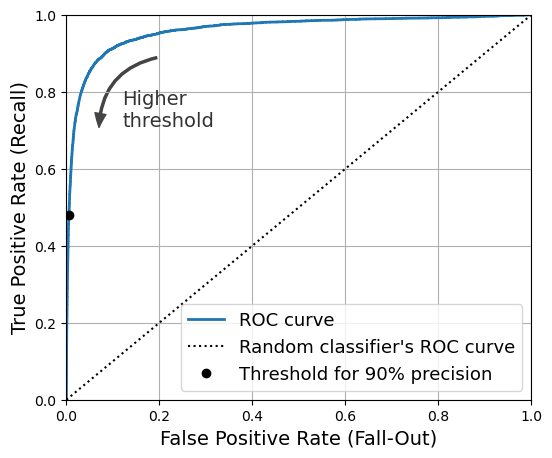

In [30]:
idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]

plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting
plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
plt.plot([fpr_90], [tpr_90], "ko", label="Threshold for 90% precision")

# extra code – just beautifies the figure
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.20, 0.89), (0.07, 0.70),
    connectionstyle="arc3,rad=.4",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.12, 0.71, "Higher\nthreshold", color="#333333")
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.grid()
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower right", fontsize=13)

plt.show()

A good classifier stays as far away from the dotted line as possible, toward the top-left corner.

One way to compare classifiers is to measure the area under the curve (AUC). A perfect classifier will have a ROC AUC equal to 1, whereas a purely random classifier will have a ROC AUC equal to 0.5. Scikit-Learn has a function to estimate this value:

In [31]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

This makes it seem as though the classifier is impressively good. However, a precision/recall (PR) curve is much better for situations where the positive class is rare or when you care more about the false positives than the false negatives. In this case, the positive class (5s) is much smaller than the negative class (not 5s). The ROC curve makes the classifier look much better than it is, whereas a PR curve shows that there's room for improvement.

Creating a `RandomForestClassifier` to compare to the `SDGClassifier`:

In [32]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)

In [33]:
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

Looking at the class probabilities for the first two images:

In [34]:
y_probas_forest[:2]

array([[0.11, 0.89],
       [0.99, 0.01]])

These are _estimated probabilities_. Among the images that the model classified as positive with a probability between 50% and 60%, there are actually about 94% positive images:

The model predicts that the first image is positive with a 89% probability and that the second image is negative with a 99% probability.

As the second column contains the estimated probabilities for the positive class, let's pass them to the `precision_recall_curve()` function:

In [35]:
y_scores_forest = y_probas_forest[:, 1]
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(
    y_train_5, y_scores_forest)

Plotting the PR curve:

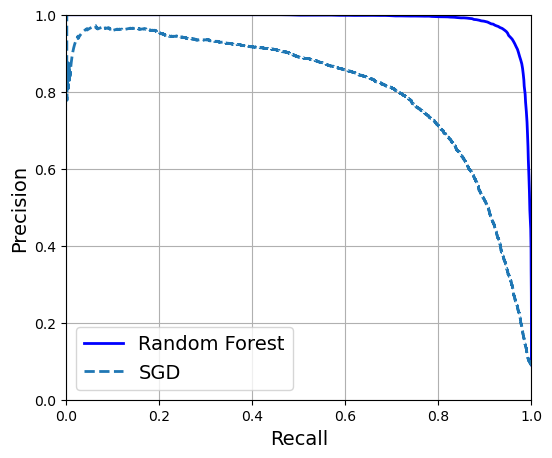

In [36]:
plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting

plt.plot(recalls_forest, precisions_forest, "b-", linewidth=2,
         label="Random Forest")
plt.plot(recalls, precisions, "--", linewidth=2, label="SGD")

# extra code – just beautifies and saves the figure
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")

plt.show()

Evidently, the random forest classifier is superior to the SGD classifier because its PR curve is much closer to the top-right corner and it has a greater AUC. Its $F_{1}$ score and ROC AUC score are also better:

In [37]:
y_train_pred_forest = y_probas_forest[:, 1] >= 0.5  # positive proba ≥ 50%
f1_score(y_train_5, y_train_pred_forest)

0.9274509803921569

In [38]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

Precision and recall scores aren't too shabby either:

In [39]:
precision_score(y_train_5, y_train_pred_forest)

0.9897468089558485

In [40]:
recall_score(y_train_5, y_train_pred_forest)

0.8725327430363402

## Multiclass classification

Whereas binary classifiers distinguish between two classes, multiclass classifiers (also called multinomial classes) can distinguish between more than two classes. Some classifiers are strictly binary, like `SVC` and `SGDClassifier`, but they can be used for multiclass classification by utilizing various strategies involving multiple binary classifiers.

* One way is to train 10 binary classifiers, one for each digit. Then when you want to classify an image, you get the decision score from each classifier for that image and select the class whose classifier outputs the highest score (_one-versus-the-rest (OvR)_ or _one-versus-all (OvA)_ strategy)

* Another way is _one-versus-one (OvO)_, where you would train a binary classifier on each pair of digits, one to distinguish between 0s and 1s, another for 1s and 2s and so on. This means training $\frac{N \cdot (N-1)}{2}$ classifiers, where N is the number of classes. For this task, that would mean training 45 classifiers. To make a prediction, you would have to run the image through all 45 classifiers and see which class wins the most duels. One advantage of this approach is that each classifier only needs to be trained on the part of the training set containing the two classes between which it has to distinguish.

Only training on the first 2,000 instances since SVMs don't scale well to large datasets:

In [41]:
from sklearn.svm import SVC

svm_clf = SVC(random_state=42)
svm_clf.fit(X_train[:2000], y_train[:2000])  # y_train, not y_train_5

SVC(random_state=42)

Since there are 10 classes (more than two), Scikit-Learn used the OvO strategy and trained 45 binary classifiers.

* It is faster to train many classifiers on small training sets than to train a few classifiers on large training sets.

* Scikit-Learn detects when you try to use a binary classification algorithm for a multiclass classification task and automatically runs OvR or OvO, depending on the algorithm.

In [42]:
svm_clf.predict([some_digit])

array(['5'], dtype=object)

Checking the scores per class, equal to the number of won duels plus or minus a small tweak to break ties:

In [43]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores.round(2)

array([[ 3.79,  0.73,  6.06,  8.3 , -0.29,  9.3 ,  1.75,  2.77,  7.21,
         4.82]])

The highest is 9.3, which is the one corresponding to class 5:

In [44]:
class_id = some_digit_scores.argmax()
class_id

5

In [45]:
svm_clf.classes_

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object)

In [46]:
svm_clf.classes_[class_id]

'5'

Using OvR in stead:

In [47]:
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC(random_state=42))
ovr_clf.fit(X_train[:2000], y_train[:2000])

OneVsRestClassifier(estimator=SVC(random_state=42))

In [48]:
ovr_clf.predict([some_digit])

array(['5'], dtype='<U1')

Using `SGDClassifier` to make predictions:

In [49]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array(['3'], dtype='<U1')

Incorrect. But prediction errors do happen sometimes!

It used OvR under the hood, since there are 10 classes it trained 10 binary classifiers:

In [50]:
sgd_clf.decision_function([some_digit]).round()

array([[-31893., -34420.,  -9531.,   1824., -22320.,  -1386., -26189.,
        -16148.,  -4604., -12051.]])

As opposed to OvO with `SVC`:

In [51]:
svm_clf.decision_function_shape = "ovo"
some_digit_scores_ovo = svm_clf.decision_function([some_digit])
some_digit_scores_ovo.round(2)

array([[ 0.11, -0.21, -0.97,  0.51, -1.01,  0.19,  0.09, -0.31, -0.04,
        -0.45, -1.28,  0.25, -1.01, -0.13, -0.32, -0.9 , -0.36, -0.93,
         0.79, -1.  ,  0.45,  0.24, -0.24,  0.25,  1.54, -0.77,  1.11,
         1.13,  1.04,  1.2 , -1.42, -0.53, -0.45, -0.99, -0.95,  1.21,
         1.  ,  1.  ,  1.08, -0.02, -0.67, -0.14, -0.3 , -0.13,  0.25]])

Evaluating the `SDGClassifier` model:

In [52]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

It gets over 85.8% on all test folds, which is pretty good. However, we can do much better. Scaling the inputs already increases accuracy above 89.1%:

In [53]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype("float64"))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

## Error Analysis

Creating a confusion matrix from predictions:

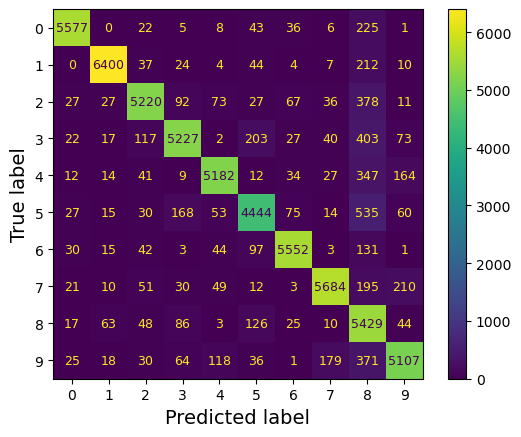

In [54]:
from sklearn.metrics import ConfusionMatrixDisplay

y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
plt.rc('font', size=9)  # extra code – make the text smaller
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred)
plt.show()

This looks pretty good, but the cell on the diagonal in row #5 and column #5 looks slightly darker than other digits. This could be because the model made more errors on 5s, or because there are fewer 5s in the dataset than other digits. That's why it's important to normalize the confusion matrix by dividing each value by the total number of images in the corresponding (true) class by setting `normalize="true"`. We can also specify the `values_format=".0%` argument to show percentages with no decimals:

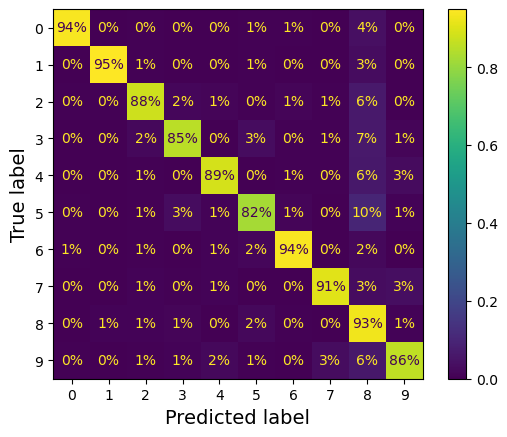

In [55]:
plt.rc('font', size=10)  # extra code
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred,
                                        normalize="true", values_format=".0%")
plt.show()

Now we can see that 82% of the images of 5s were classified correctly.

* 10% of 5s were misclassified as 8s
* 2% of 8s were misclassified as 5s
* Many digits have been misclassified as 8s, but that's not immediately obvious from this diagram

Putting zero weight on the correct predictions to make the errors stand out more:

Normalized by row:



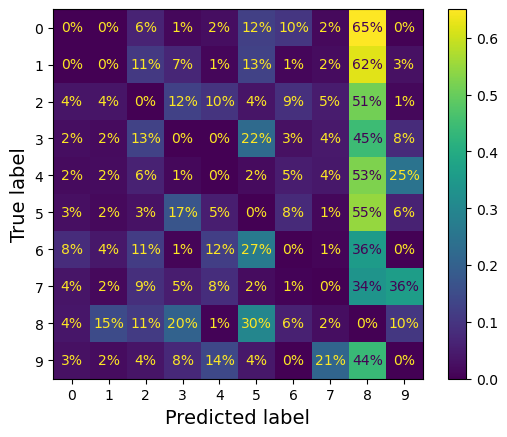

In [56]:
sample_weight = (y_train_pred != y_train)
plt.rc('font', size=10)  # extra code
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred,
                                        sample_weight=sample_weight,
                                        normalize="true", values_format=".0%")
print("Normalized by row:\n")
plt.show()

This confirms that many images got misclassified as 8s. Remember that correct predictions have been excluded here, for example:

* 36% in row #7, column #9 means that 36% of the errors the model made on images of 7s were misclassified as 9s.

It seems that efforts should be spent on reducing the false 8s, as there are so many. Analyzing individual errors can also be a good way to gain insights into what the classifier is doing and why it's failing. Here's examples of 3s and 5s in a confusion matrix style:

In [57]:
cl_a, cl_b = '3', '5'
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

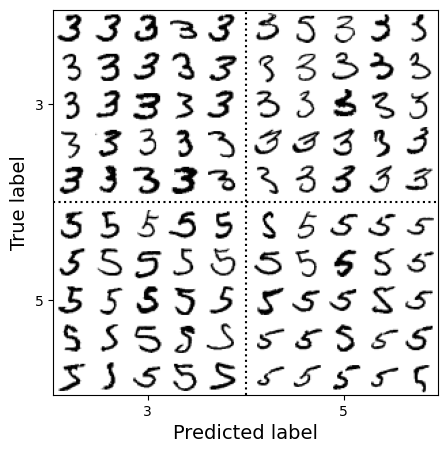

In [58]:
# extra code – this cell generates the figure
size = 5
pad = 0.2
plt.figure(figsize=(size, size))
for images, (label_col, label_row) in [(X_ba, (0, 0)), (X_bb, (1, 0)),
                                       (X_aa, (0, 1)), (X_ab, (1, 1))]:
    for idx, image_data in enumerate(images[:size*size]):
        x = idx % size + label_col * (size + pad)
        y = idx // size + label_row * (size + pad)
        plt.imshow(image_data.reshape(28, 28), cmap="binary",
                   extent=(x, x + 1, y, y + 1))
plt.xticks([size / 2, size + pad + size / 2], [str(cl_a), str(cl_b)])
plt.yticks([size / 2, size + pad + size / 2], [str(cl_b), str(cl_a)])
plt.plot([size + pad / 2, size + pad / 2], [0, 2 * size + pad], "k:")
plt.plot([0, 2 * size + pad], [size + pad / 2, size + pad / 2], "k:")
plt.axis([0, 2 * size + pad, 0, 2 * size + pad])
plt.xlabel("Predicted label")
plt.ylabel("True label")

plt.show()

A simple `SDGClassifier` was used, which is a linear model. It assigns a weight per class to each pixel, and when presented with a new image it sums up the weighted pixel intensities to get a score for each class. 

3s and 5s only differ by a few pixels, so this model easily confuses them.

The main difference between 3s and 5s is the position of the small line that joins the top line to the bottom arc. This classifier is quite sensitive to image shifting and rotation, as a shifted 3 could easily be mistaken for a 5.

A possible fix is to augment the training set with slightly shifted and rotated variants of the training images, forcing the model to learn to be more tolerant to such variations.

## Multilabel Classification

Multilabel classification is when a classifier outputs multiple classes for each instance. For example, in face recognition there could be multiple people in a picture, so the classifier would need to output one class for each person it identifies.

In the following example a `y_multilabel` array is created containing two target labels for each digit image:

* The first indicates whether or not it's large
* The second indicates whether or not it's odd

Then a `KNeighborsClassifier` instance is created (which supports multilabel classification) and trains this model using the multiple targets array.

In [59]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= '7')
y_train_odd = (y_train.astype('int8') % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

Making a prediction:

In [65]:
knn_clf.predict([some_digit])

array([[False,  True]])

The digit 5 is indeed not large (False) and odd (True)!

Evaluating the classifier by computing the average $F_{1}$ score across all labels:

In [61]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

This approach assumes that all labels are equally important, which may not be the case. For example (for a face-recognition system of Alice, Bob and Charlie) if there are many more pictures of Alice than of Bob or Charlie, you may want to give more weight to the classifier's score on pictures of Alice.

One way to do this is to give each label a weight equal to its support (the number of instances with the target label). This can easily be done by setting `average="weighted"` when calling `f1_score()`

It's also possible to use a classifier that does not natively support multilabel classification, such as `SVC`. One model is trained per label, and the models are organized in a chain: when a model makes a prediction, iit uses the input features plus all the predictions of the models that come before it in the chain.

Scikit-Learn's `ChainClassifier` does exactly that:

In [62]:
from sklearn.multioutput import ClassifierChain

chain_clf = ClassifierChain(SVC(), cv=3, random_state=42)
chain_clf.fit(X_train[:2000], y_multilabel[:2000])

ClassifierChain(base_estimator=SVC(), cv=3, random_state=42)

In [63]:
chain_clf.predict([some_digit])

array([[0., 1.]])